In [1]:
import numpy as np
import scipy as sp
import heartpy as hp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from biosppy.signals import ecg
import hvr
import glob, os
import wave_morph as wm

%matplotlib inline

# Heart Rate Variability
### Heart rate variability measures variations in intervals between heartbeats
In this section I explore measures of heart rate variabilty as they pertain to heart rate variability (HRV)

### Let's check out some sample PPG signals

Text(0.5, 0, 'Time (s)')

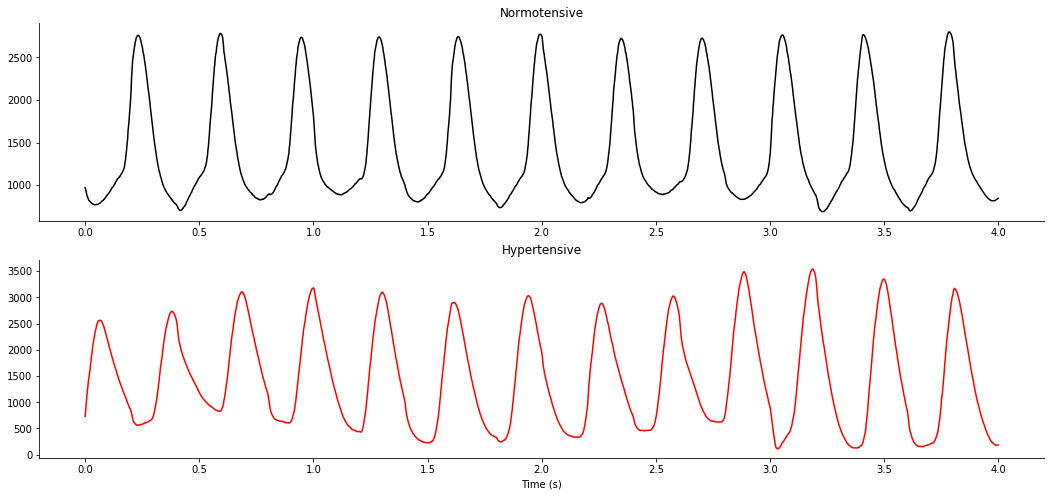

In [2]:
#Sample PPGs

#Load data from example normotensive patient
N = pd.read_csv('Copy of D45 Normotensive.csv')
ppg_n = np.array(N['ppg'])

#Load data from example hypertensive patient
H = pd.read_csv('Copy of D44 Hypertensive N Baa.csv')
ppg_h = np.array(H['ppg'])

X = np.linspace(0,4,2000)

plt.figure(figsize=(18,8))

var = [ppg_n,ppg_h]
names = ['Normotensive','Hypertensive']
colors = ['k','r']

for i in range(0,2):
    
    ax = plt.subplot(2,1,i+1)
    
    plt.plot(X,var[i][4000:6000],colors[i],linewidth=1.5)
    plt.title(names[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.xlabel('Time (s)')

## Next I run HeartPy functions to get some key HVR stats

In [3]:
#Get NN file for each file in directory
NN = hvr.full_session_stats()

In [4]:
#Pandas dataframe
NN

,hr,ibi,sdnn,rmssd,pnn50,Hypertension
0,97.298384,616.659778,49.939629,40.838576,0.149942,-1
1,88.950543,674.532141,64.864304,52.163152,0.258465,1
2,94.462328,635.173844,38.729505,36.107077,0.107014,1
3,84.382137,711.050967,41.732421,33.757269,0.045295,0
4,73.854552,812.407611,93.046002,76.992525,0.485897,0


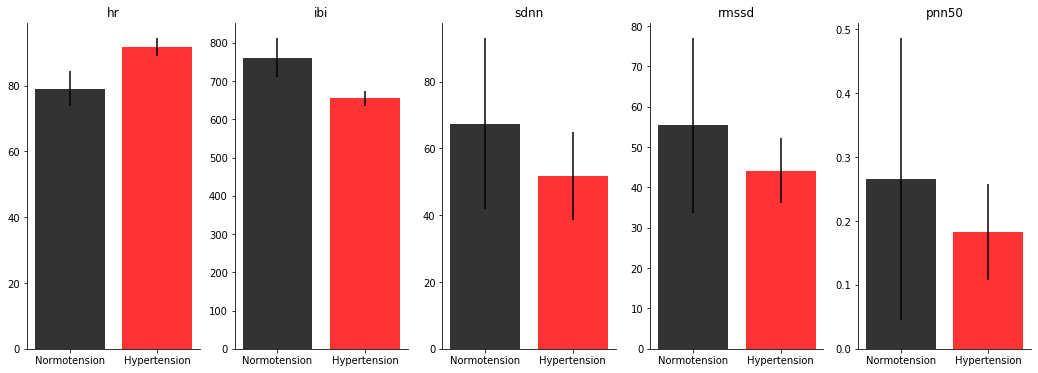

In [5]:
#Look at key stats
hvr.compare_stats(NN)

In [111]:
#Let's check out those interburst intervals
peak_dfs = {}
class_labels = {}
for file in glob.glob('*.csv'):
    
    #String to save as key in dictionaries
    name_pre = file.split()[2]
        
    if 'hyper' in file.lower():
        f_class = 1
    elif 'norm' in file.lower():
        f_class = 0
    elif 'hypo' in file.lower():
        f_class = -1
        continue
    else:
        continue
        
    if 'D46' in file:
        fs = 500
    else:
        fs = 250 
        
    #Get peaks from peaks function  
    peaks = hvr.get_ppg_peaks(file,fs)
 
    #Add to dict
    peak_dfs[name_pre] = peaks
    class_labels[name_pre] = f_class

In [7]:
#Peaks dataframe
peak_dfs['D43'].head(10)

,peak_time,peak_value
51,208000,2078
216,868000,2323
378,1516000,2320
542,2172000,2371
701,2808000,2319
874,3500000,2384
1036,4148000,2197
1200,4804000,2308
1361,5448000,2306
1522,6092000,2146


### Let's visualise some of that variability in IBI
Here I'll plot a histogram distribution

In [8]:
from scipy import stats
def IBI_hist(peaks,s_name,x_lab):
    '''
    Plot histogram distribution of IBIs and compute KS stat
    '''
    norm = []
    hyp = []
    for key, value in peaks.items():
        
        #Get times column
        t = np.diff(np.array(peaks[key]['peak_time'], dtype=float))
        
        
        #Remove NaN values
        t /= 1000
        t = t[np.logical_not(np.isnan(t))]
        if class_labels[key] == 0:
            norm.append(t)
        else:
            hyp.append(t)
    
    fig = plt.figure(figsize=(12,4))
    sns.distplot(np.hstack(norm),color='k',bins=100,norm_hist=True,label='Normotensive')
    sns.distplot(np.hstack(hyp),color='r',bins=100,norm_hist=True,label='Hypertensive')
    plt.title(s_name)
    plt.ylabel('Proportion of total')
    plt.xlabel(x_lab)
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
    plt.legend()
    
    print(stats.ks_2samp(np.hstack(norm),np.hstack(hyp)))

Ks_2sampResult(statistic=0.5568077467476596, pvalue=1.0)


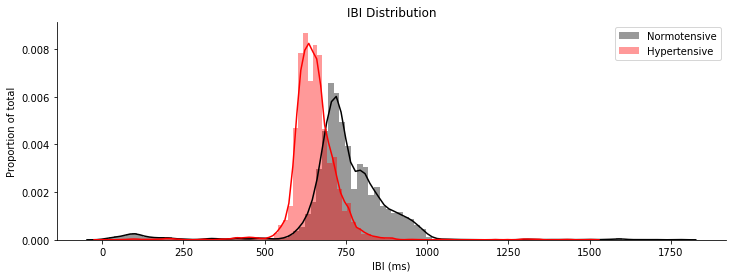

In [9]:
IBI_hist(peak_dfs,'IBI Distribution','IBI (ms)')

## Heart Rate Variability indicates changes in measures of the heart with time
### Let's visualise how these various alter at different timepoints within the recording session

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


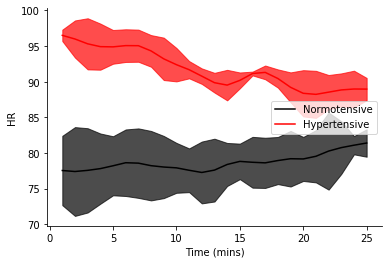

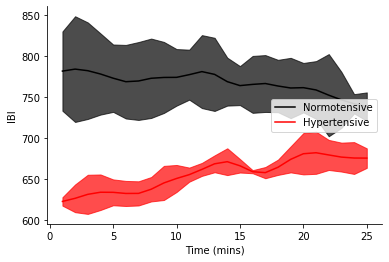

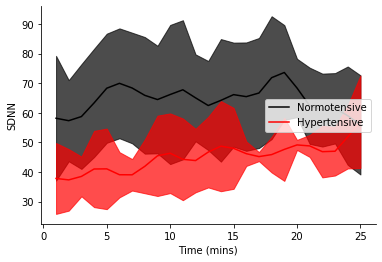

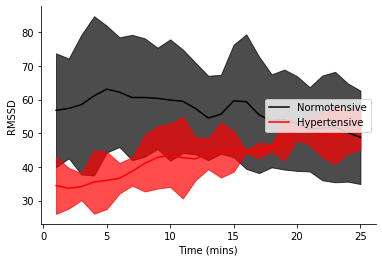

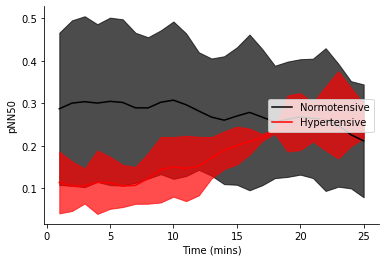

In [10]:
#What about changes over time - 2 minute window (1 minute intervals)
hr, ibi, sdnn, rmssd, pnn50 = hvr.hypertension_v_time(2,1)

hyp_hr,norm_hr = hvr.plot_stat_v_time(hr,'HR',1,True,1)
hyp_ibi,norm_ibi = hvr.plot_stat_v_time(ibi,'IBI',1,True,1)
_,_ = hvr.plot_stat_v_time(sdnn,'SDNN',1,True,1)
_,_ = hvr.plot_stat_v_time(rmssd,'RMSSD',1,True,1)
_,_ = hvr.plot_stat_v_time(pnn50, 'pNN50',1,True,1)

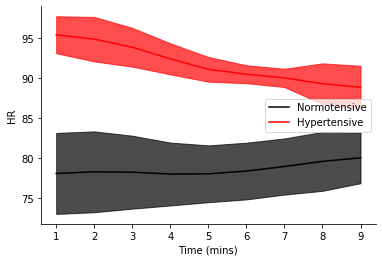

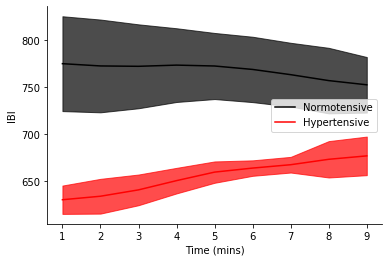

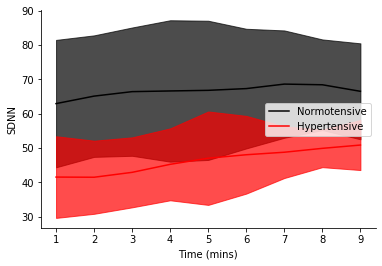

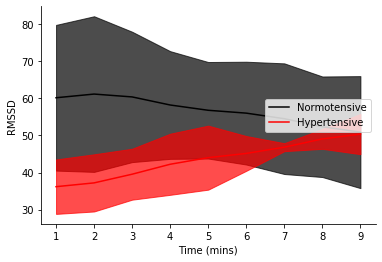

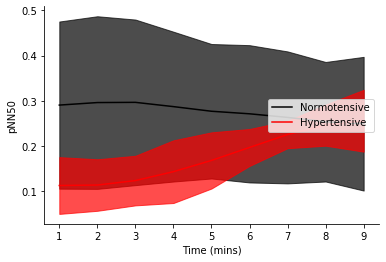

In [11]:
#What about changes over time - 5 minute window
hr, ibi, sdnn, rmssd, pnn50 = hvr.hypertension_v_time(5,2.5)

hyp_hr,norm_hr = hvr.plot_stat_v_time(hr,'HR',1,True,1)
hyp_ibi,norm_ibi = hvr.plot_stat_v_time(ibi,'IBI',1,True,1)
_,_ = hvr.plot_stat_v_time(sdnn,'SDNN',1,True,1)
_,_ = hvr.plot_stat_v_time(rmssd,'RMSSD',1,True,1)
_,_ = hvr.plot_stat_v_time(pnn50, 'pNN50',1,True,1)

### HR and IBI appear to show a difference in their values at the start vs. end of the session
Let's visualise that change

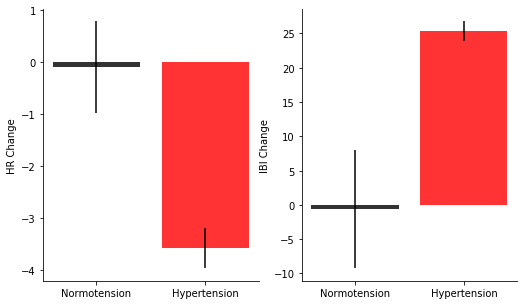

In [12]:
plt.figure(figsize=(8.5,5))
ax = plt.subplot(1,2,1)
hvr.meas_change(hyp_hr,norm_hr,1,'HR Change')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(1,2,2)
hvr.meas_change(hyp_ibi,norm_ibi,1,'IBI Change')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Finally what to individual waveforms look like?
### Here we'll look at time-invariant normalized waveforms
* This way we're only looking at shape and not measures like frequency or amplitude

In [112]:
#Look at average waveform
wfs = {}
for file in glob.glob('*.csv'):
    
    #String to save as key in dictionaries
    name_pre = file.split()[2]
    
    df = pd.read_csv(file)
        
    if 'hyper' in file.lower():
        f_class = 1
    elif 'norm' in file.lower():
        f_class = 0
    elif 'hypo' in file.lower():
        f_class = -1
        continue
    else:
        continue
        
    if 'D46' in file:
        fs = 500
    else:
        fs = 250 
    
    ppg_sig = np.array(df['ppg'])
    ppg_ts = np.array(df['time'])
    ppg_pts = np.array(peak_dfs[name_pre]['peak_time'])
    
    wf = wm.av_wf(ppg_sig,ppg_ts,ppg_pts)
    
    wfs[name_pre] = wf

Text(0.5, 1.0, 'Hypertensive')

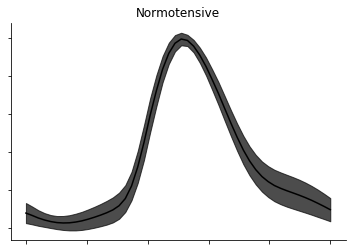

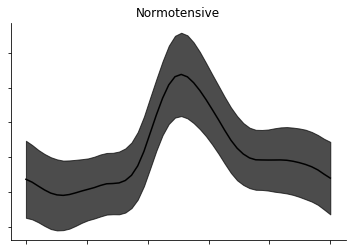

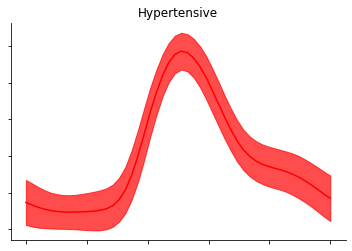

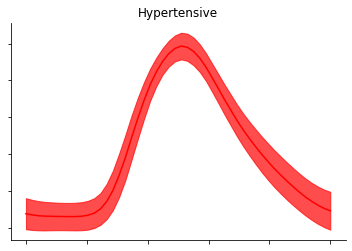

In [121]:
wm.plot_av_wf(wfs['D45'],'k')
plt.title('Normotensive')

wm.plot_av_wf(wfs['D46'],'k')
plt.title('Normotensive')

wm.plot_av_wf(wfs['D43'],'r')
plt.title('Hypertensive')

wm.plot_av_wf(wfs['D44'],'r')
plt.title('Hypertensive')

### Are there correlations between participants in their waveforms shape?

In [127]:
from scipy import stats

H1 = wfs['D43'].mean(axis=0)
H2 = wfs['D44'].mean(axis=0)

N1 = wfs['D45'].mean(axis=0)
N2 = wfs['D46'].mean(axis=0)

all_wvs = pd.DataFrame({'H1':H1,'H2':H2,'N1':N1,'N2':N2})

Text(0.5, 1, 'Correlation between average waveforms')

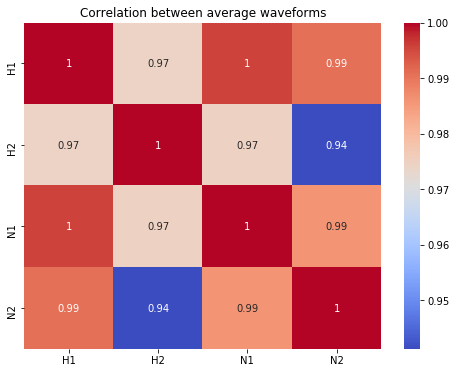

In [144]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(all_wvs.corr(),annot=True,cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation between average waveforms')